<a href="https://colab.research.google.com/github/mneedham/data-science-training/blob/master/04_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictions

In this notebook we're going to learn how to build a link prediction classifier using Neo4j and scikit-learn. Let's start by importing the libraries that we'll need:

In [1]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

Now we need to create a connection to our Neo4j Sandbox. 

<div align="left">
    <img src="images/sandbox-citations2.png" alt="Neo4j 3.4 Sandbox"/>
</div>

We'll need to update the cell below to use the IP Address, Bolt Port, and Password.

In [10]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
# graph = Graph("bolt://34.239.255.86:34057", auth=("neo4j", "swords-measurements-routines"))
graph = Graph("bolt://34.239.255.86:34086", auth=("neo4j", "column-chokes-head"))

## Building a co-author graph

We're going to build an inferred graph of co-authors based on people collaborating on the same papers. We're also going to store a property on the relationship indicating the year of their first collaboration.

We can run the query below to do this:

In [8]:
query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, paper
   ORDER BY a1, paper.year
   RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations", 
  {batchSize: 100})
"""

graph.run(query).stats()

DatabaseError: Could not apply the transaction to the store after written to log

Now that we've created our co-author graph, we want to come up with an approach that will allow us to predict future links (relationships) that will be created between people. 

We're going to use the [link prediction algorithms](https://neo4j.com/docs/graph-algorithms/current/algorithms/linkprediction/) that we learnt about in the previous section, but once we've computed scores with this algorithms what should we do?

There are two main approaches that we can take:

### Using the measures directly

We can use the scores from the link predictions directly, specifying a __threshold value__ above which we predict that a link will be created between two nodes.

### Supervised learning

We can take a supervised learning approach where we use the scores as features to train a binary classifier. The binary classifier then predicts whether a pair of nodes will have a link.

In this notebook we're going to learn how to apply the supervised learning approach.

## Train and test datasets 

Now that we've decided we're going to use a machine learning approach, we need to come up with train and test datasets on which we can build, and then evaluate a model.

### Positive examples

The tricky thing when working with graph data is that we can't just randomly split the data, as this could lead to data leakage.

Data leakage can occur when data outside of your training data is inadvertently used to create your model. This can easily happen when working with graphs because pairs of nodes in our training set may be connected to those in the test set.

When we compute link prediction measures over that training set the __measures computed contain information from the test set__ that we’ll later evaluate our model against.

Instead we need to split our graph into training and test sub graphs. If our graph has a concept of time our life is easy — we can split the graph at a point in time and the training set will be from before the time, the test set after.

This is still not a perfect solution and we’ll need to try and ensure that the general network structure in the training and test sub graphs is similar.

Once we’ve done that we’ll have pairs of nodes in our train and test set that have relationships between them. They will be the __positive examples__ in our machine learning model.

We are lucky that our citation graph contains a times. We can create train and test graphs by splitting the data on a particular year. Now we need to figure out what year that should be. Let's have a look at the distribution of the first year that co-authors collaborated:

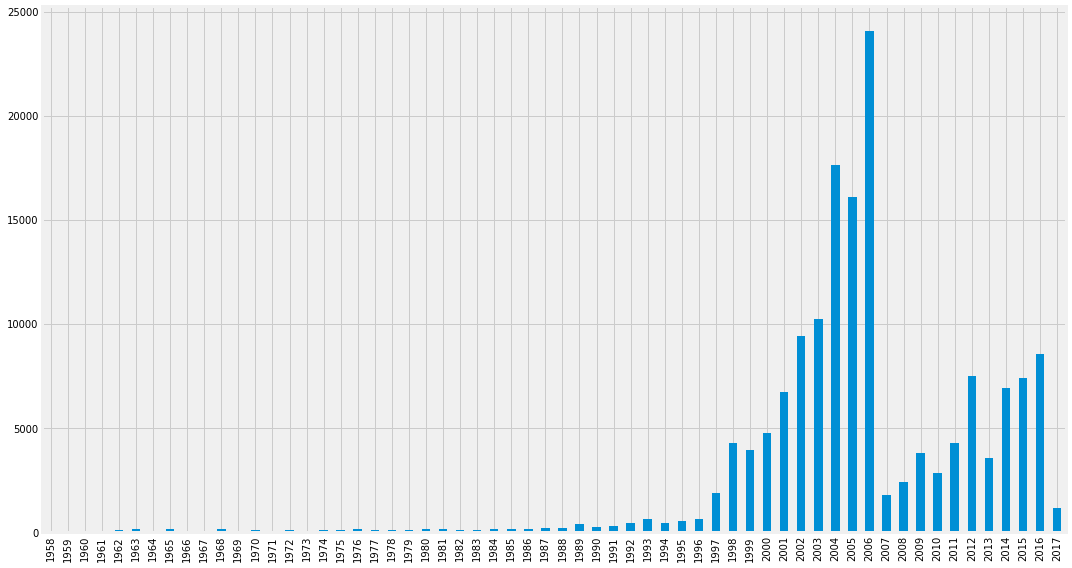

In [11]:
query = """
MATCH p=()-[r:CO_AUTHOR]->() 
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

It looks like 2006 would act as a good year on which to split the data. We'll take all the co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.

Let's create explicit `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships in our graph based on that year. The following code will create these relationships for us:

In [12]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 81096
relationships_created: 81096
relationships_deleted: 0

In [13]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 74128
relationships_created: 74128
relationships_deleted: 0

Let's quickly check how many co-author relationship we have in each of these sub graphs:

In [14]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [15]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


We have a split of 52-48, which is a bit on the high side, but should be ok. Now for the __negative examples__.

### Negative examples

The simplest approach would be to use all pair of nodes that don’t have a relationship. __The problem with this approach is that there are significantly more examples of pairs of nodes that don’t have a relationship than there are pairs of nodes that do__.

The maximum number of negative examples is equal to:

```
# negative examples = (# nodes)² - (# relationships) - (# nodes)
```

i.e. the number of nodes squared, minus the relationships that the graph has, minus self relationships.

If we use all of these negative examples in our training set we will have a massive class imbalance — there are many negative examples and relatively few positive ones.

A model trained using data that’s this imbalanced will achieve very high accuracy by __predicting that any pair of nodes don’t have a relationship__ between them, which is not quite what we want!

So we need to try and reduce the number of negative examples. An approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__.

This will significantly reduce the number of negative examples, although there will still be a lot more negative examples than positive.

To solve this problem we either need to down sample the negative examples or up sample the positive examples.

We're going to take the down sampling approach in this guide, and the following function will do this for us:

In [16]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

Now we're ready to build our train and test datasets based on the train and test sub graphs that we created. 

* The positive examples will be taken directly from the graph. 
* Our negative examples will be found by looking for people who are 2 or 3 hops away from each other, excluding those that have already collaborated. We'll then down sample those examples to equal the size of the positive examples 

In [17]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [ ]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

Now let's have a look what our train DataFrame contains:

In [ ]:
training_df.head()

Let's repeat the process for the test set:

In [ ]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [ ]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

And it's time to sample our test DataFrame:

In [ ]:
test_df.head()

# Choosing a machine learning algorithm

We’ll create our machine learning pipeline based on a random forest classifier. This method is well suited as our data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure we don’t create a model that only fits our training data.

In [ ]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

# Generating graphy features

We’ll start by creating a simple model that tries to predict whether two authors will have a future collaboration based on features extracted from common authors, preferential attachment, and the total union of neighbors.

The following function computes each of these measures for pairs of nodes:

In [ ]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

Let's apply the function to our training DataFrame:

In [ ]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

And this is what our DataFrame looks like now:

In [ ]:
training_df.head()

Now let's do the same to our test DataFrame:

In [ ]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [ ]:
test_df.head()

Now let's build a model based on these graphy features. We'll start by just using one of the features - common neighbors. 

The following code builds a random forest model, evaluates it against the test dataset, and then indicates which of the features had the most importance in the model.

In [ ]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

Now we need to evalute our model. We're going to compute its accuracy, precision, and recall. After we've done that we'll return the importance of each feature used in our model. The following functions will help with this:

In [ ]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [ ]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The scores for accuracy and precision aren't bad, but our recall isn't very good. Let's see what happens if we include preferential attachment and total neighbors as well:

In [ ]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Common Neighbors is the dominant feature, but including the two other features has improved the accuracy and recall of our model.

Now we're going to add some new features that are generated from graph algorithms.

# Triangles and The Clustering Coefficient

We'll start by running the [triangle count](https://neo4j.com/docs/graph-algorithms/current/algorithms/triangle-counting-clustering-coefficient/) algorithm over our test and train sub graphs. This algorithm will return the number of triangles that each node forms, as well as each node's clustering coefficient. The clustering coefficient of a node indicates the likelihood that its neighbours are also connected.

In [ ]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR_EARLY', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

In [ ]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

The following function will add these features to our train and test DataFrames:

In [ ]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

Let's add the new features:

In [ ]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [ ]:
training_df.head()

In [ ]:
test_df.head()

And now let's train and evaluate a model with these features:

In [ ]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The coefficient features haven't added much to our model, but the triangles are useful. Next we're going to see if community detection algorithms can help improve our model.

# Community Detection

Community detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities.

We'll run two community detection algorithms over the train and test sub graphs - Label Propagation and Louvain. First up, Label Propagation: 

In [ ]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

In [ ]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

And now Louvain. The Louvain algorithm returns intermediate communities, which are useful for finding fine grained communities that exist in a graph. We'll add a property to each node containing the community revealed on the first iteration of the algorithm:

In [ ]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

In [ ]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

The following function will add these features to our train and test DataFrames:

In [ ]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [ ]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [ ]:
training_df.head()

In [ ]:
test_df.head()

In [ ]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)